SVM模型评估指标:
准确率: 0.5516483516483517
精确度: 0.5669014084507042
召回率: 0.6652892561983471
F1值: 0.612167300380228


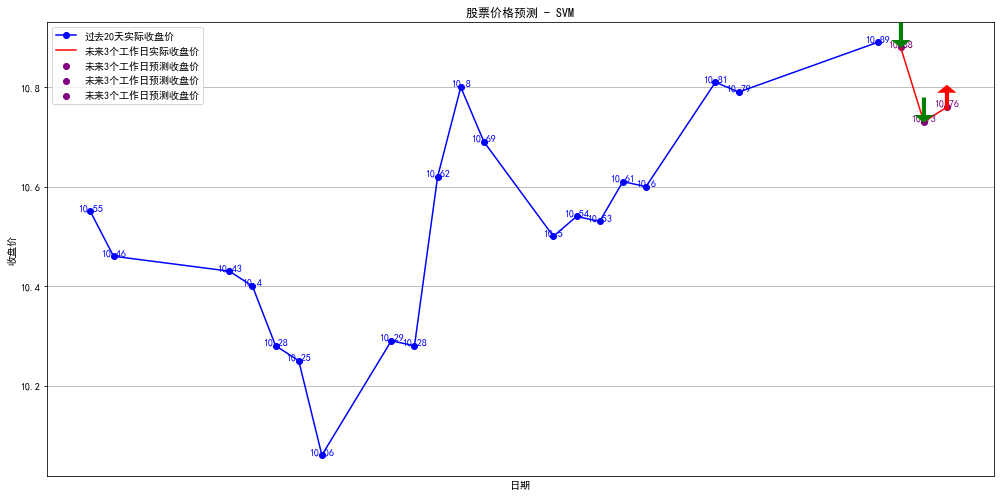

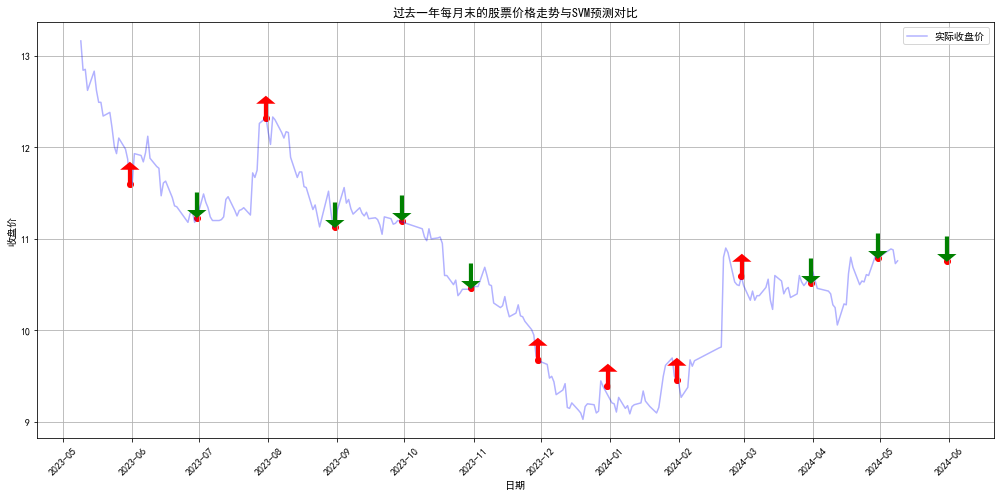

In [4]:
import tushare as ts
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

plt.rcParams['font.family'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号



# 输入您的tushare token
token = '9a1f6d0d30ffa2cd207f8ec1fafbdc1bb581163b3246a839d85504ff'
ts.set_token(token)
pro = ts.pro_api()

# 获取股票数据
df = pro.query('daily', ts_code='000001.SZ', start_date='20150101', end_date='20240509')

# 将数据保存到CSV文件中
df.to_csv('000001_SZ.csv')

# 加载数据
df = pd.read_csv('000001_SZ.csv')

# 计算涨跌情况
df['涨跌'] = np.where(df['close'] - df['close'].shift(1) > 0, 1, 0)

# 选择特征列和标签列
X = df[['open', 'close', 'high', 'low', 'vol']]
y = df['涨跌']

# 数据标准化处理
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 构建SVM模型并使用网格搜索调参
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}
svm_model = GridSearchCV(SVC(), param_grid, cv=5)
svm_model.fit(X_train, y_train)

# 预测结果
y_pred = svm_model.predict(X_test)


# 模型评估
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("SVM模型评估指标:")
print("准确率:", accuracy)
print("精确度:", precision)
print("召回率:", recall)
print("F1值:", f1)

# 将日期索引转换为日期时间对象
df.index = pd.to_datetime(df['trade_date'], format='%Y%m%d')

# 反转数据顺序
df = df[::-1]

# 获取过去20天的数据索引
past_indices = df.index[-23:-3]

# 获取未来3个工作日的索引
future_indices = df.index[-3:]

# 设置图形大小
plt.figure(figsize=(14, 7))

# 绘制过去20天的实际收盘价
plt.plot(past_indices, df.loc[past_indices, 'close'], 'bo-', label='过去20天实际收盘价')

# 标记过去20天每天的收盘价点，并只在有数据的日期上显示时间标签
for idx in past_indices:
    if idx in df.index:
        plt.text(idx, df.loc[idx, 'close'], str(df.loc[idx, 'close']), fontsize=10, color='blue', ha='center', va='bottom')

# 绘制未来三天的预测收盘价并连接成线
plt.plot(future_indices, df.loc[future_indices, 'close'], 'r-', label='未来3个工作日实际收盘价')

# 绘制预测的收盘价点
for i, idx in enumerate(future_indices):
    plt.scatter(idx, df.loc[idx, 'close'], color='purple', marker='o', label='未来3个工作日预测收盘价')
    if idx in df.index:
        plt.text(idx, df.loc[idx, 'close'], str(df.loc[idx, 'close']), fontsize=10, color='purple', ha='center', va='bottom')

# 绘制预测的涨跌趋势
for i, idx in enumerate(future_indices):
    if y_pred[-3+i] == 1:
        plt.text(idx, df.loc[idx, 'close'], '↑', fontsize=32, color='red', ha='center')
    else:
        plt.text(idx, df.loc[idx, 'close'], '↓', fontsize=32, color='green', ha='center')

plt.title('股票价格预测 - SVM')
plt.xlabel('日期')
plt.ylabel('收盘价')
plt.legend()
plt.grid(True)
plt.xticks([])
plt.tight_layout()
plt.show()





# 加载数据
df = pd.read_csv('000001_SZ.csv')

# 确保date列转换为日期格式，并设置为索引
df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
df.set_index('trade_date', inplace=True)

# 截取过去一年的数据
start_date = df.index.max() - pd.DateOffset(years=1)
df = df[df.index >= start_date]

# 计算涨跌情况
df['涨跌'] = np.where(df['close'] - df['close'].shift(1) > 0, 1, 0)

# 按月选择数据
monthly_data = df.resample('M').last()

# 选择特征列和标签列
X = monthly_data[['open', 'close', 'high', 'low', 'vol']]
y = monthly_data['涨跌']

# 数据标准化处理
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 构建SVM模型并使用网格搜索调参
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}
svm_model = GridSearchCV(SVC(), param_grid, cv=5)
svm_model.fit(X_scaled, y)

# 预测结果
y_pred = svm_model.predict(X_scaled)

# 设置图形大小
plt.figure(figsize=(14, 7))

# 绘制实际走势
plt.plot(df.index, df['close'], label='实际收盘价', color='blue', alpha=0.3)  # 使用透明度以凸显每月数据点

# 标记每个月的预测结果
for i, date in enumerate(monthly_data.index):
    plt.scatter(date, monthly_data.loc[date, 'close'], color='red')  # 月末数据点
    if y_pred[i] == 1:
        plt.text(date, monthly_data.loc[date, 'close'], '↑', fontsize=32, color='red', ha='center')
    else:
        plt.text(date, monthly_data.loc[date, 'close'], '↓', fontsize=32, color='green', ha='center')

# 设置日期格式
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title('过去一年每月末的股票价格走势与SVM预测对比')
plt.xlabel('日期')
plt.ylabel('收盘价')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



